##Augmenting Satellite Imagery for Airplane Detection Using Stable Diffusion Inpainting
##Created By: Shawn Oyer, Drexel University, CS 614 Course
##Date: 7/26/2024

##Data for this project can be downloaded at https://drive.google.com/file/d/10oakKU-DFtDWGPDiTs2x7IqZ82FfwauN/view

##Utilities

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
nbdir = "/content/gdrive/MyDrive/CS_614/Project1"

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/CS_614/Project1/

/content/gdrive/MyDrive/CS_614/Project1


In [ ]:
!pip install -U huggingface_hub
!pip install diffusers["torch"] transformers accelerate
!pip install pycocotools
!pip install torchmetrics[image]
!pip install torch-fidelity
!pip install -U --pre triton
!pip install xformers
!pip install pytorch-fid

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.0/419.0 kB 11.4 MB/s eta 0:00:00
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.23.5
    Uninstalling huggingface-hub-0.23.5:
      Successfully uninstalled huggingface-hub-0.23.5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 24.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5

In [ ]:
import os
from google.colab import drive
import numpy as np
from matplotlib import pyplot as plt
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.utils import make_grid
import math
import random
import json
from pytorch_fid import fid_score
import shutil

import argparse
import itertools
import math
import os
import random
import PIL
import requests
import torch
from io import BytesIO
import matplotlib.pyplot as plt

from diffusers import StableDiffusionInpaintPipeline

import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from torch.utils.data import Dataset
from torchmetrics.image.fid import FrechetInceptionDistance
from sklearn.metrics import accuracy_score
from skimage.metrics import structural_similarity as ssim

import cv2
import PIL
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed
from diffusers import StableDiffusionInpaintPipeline
from diffusers.optimization import get_scheduler
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, DDPMScheduler
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import StableDiffusionInpaintPipeline
from diffusers import StableDiffusionPipeline
import accelerate

from pycocotools.coco import COCO
import multiprocessing

%matplotlib inline

cores = multiprocessing.cpu_count()
print(f"There are {cores} cores in the CPU")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

There are 8 cores in the CPU


##Testing Examples

**Users need access to the Synthetic Train Folder and Synthetic Train Masks (coco.json) in addition to the Model location (sd-satellite-airplanes) to run this code. Also users need to run the Utilities section first.**


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Enter the size for the airplane (e.g., 'large, small, long, short, etc'): large
Enter the color of the airplane wings (e.g., 'blue, red, yellow, black, etc'): blue
Enter a description for the background (e.g., 'urban, snow, forest, etc'): pyramids
loading annotations into memory...
Done (t=1.65s)
creating index...
index created!


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

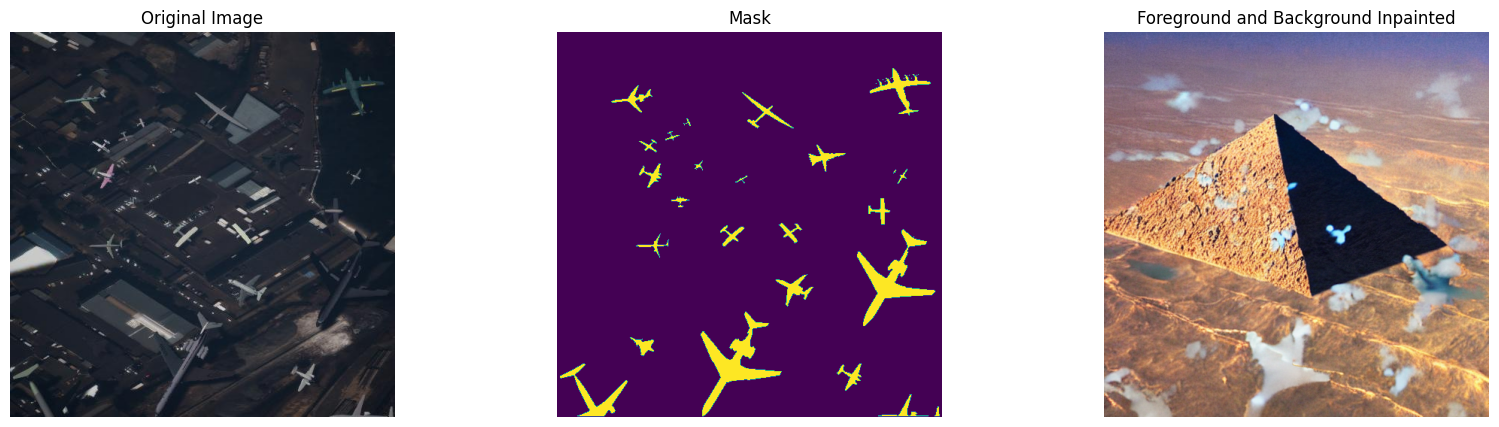

In [ ]:
# Provided Testing Example to Ensure the Code Runs as intended. Loads the trained custom Stable Diffusion Inpaint Pipeline, acquires the Image and Masks,
# Prompts the User for Foreground Size and Color and Background Value, and generates the Real Image, Masked Image, and the new Synthetic Image based on the user input in the prompts.
#################### RUN THIS CODE AND FOLLOW THE PROMPTS

# Load the pipeline
pipeline = StableDiffusionInpaintPipeline.from_pretrained(
    "sd-satellite-airplanes",
    torch_dtype=torch.float16
).to("cuda")

# Load the images and masks
def get_img_and_masks(idx, create_room=False):
    coco = COCO('./data/synthetic_train_coco.json')
    img_dir = './data/synthetic_train'
    image_id = idx

    # Load image info
    img_info = coco.loadImgs(image_id)[0]

    # Load image
    init_image = np.array(Image.open(os.path.join(img_dir, img_info['file_name'])))

    # Load annotations
    ann_ids = coco.getAnnIds(imgIds=img_info['id'], iscrowd=None)
    anns = coco.loadAnns(ann_ids)

    # Initialize mask image
    mask_image = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)

    # Aggregate masks
    for ann in anns:
        mask_image += coco.annToMask(ann)

    # Ensure mask is binary
    mask_image = np.clip(mask_image, 0, 1) * 255

    # Create room around objects if specified
    if create_room:
        # Implement room creation
        shift_val = 5
        inv_mask = mask_image.copy()
        inv_mask += np.roll(mask_image, shift_val, axis=0)  # Translate the mask 5 pixels to the bottom
        inv_mask += np.roll(mask_image, -shift_val, axis=0)  # Translate the mask 5 pixels to the top
        inv_mask += np.roll(mask_image, shift_val, axis=1)  # Translate the mask 5 pixels to the right
        inv_mask += np.roll(mask_image, -shift_val, axis=1)  # Translate the mask 5 pixels to the left
        inv_mask = np.clip(inv_mask, 0, 1) * 255
        inv_mask = np.uint8(np.where(inv_mask > 0, 0, 1))

    else:
        inv_mask = np.uint8(np.where(mask_image > 0, 0, 1))

    return init_image, mask_image, inv_mask

# Display the images
def display_images(images, titles):
    fig, ax = plt.subplots(1, len(images), figsize=(20, 5))
    for i, (img, title) in enumerate(zip(images, titles)):
        ax[i].imshow(img)
        ax[i].set_title(title)
        ax[i].axis('off')
    plt.show()

# User input for prompts
foreground_size = input("Enter the size for the airplane (e.g., 'large, small, long, short, etc'): ")
foreground_color = input("Enter the color of the airplane wings (e.g., 'blue, red, yellow, black, etc'): ")
background_value = input("Enter a description for the background (e.g., 'urban, snow, forest, etc'): ")

# Construct prompts using placeholders
foreground_prompt = f"A {foreground_size} airplane high resolution as viewed from a satellite with {foreground_color} wings."
background_prompt = f"High resolution {background_value} as viewed from a satellite."

# Single image with both foreground and background
idx = 1  # Replace with the desired image index

# Load image and masks
img, mask, inv_mask = get_img_and_masks(idx)

# Generate foreground image
generated_foreground_image = pipeline(prompt=foreground_prompt, image=img, mask_image=mask).images[0]

# Generate background image using the foreground image
generated_background_image = pipeline(prompt=background_prompt, image=generated_foreground_image, mask_image=inv_mask).images[0]

# Display images: Original image, mask, and final inpainted image
display_images([img, mask, generated_background_image],
                ['Original Image', 'Mask', 'Foreground and Background Inpainted'])

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Enter the size for the airplane (e.g., 'large, small, long, short, etc'): short
Enter the color of the airplane wings (e.g., 'blue, red, yellow, black, etc'): red
Enter a description for the background (e.g., 'urban, snow, forest, etc'): parking apron
loading annotations into memory...
Done (t=1.60s)
creating index...
index created!


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

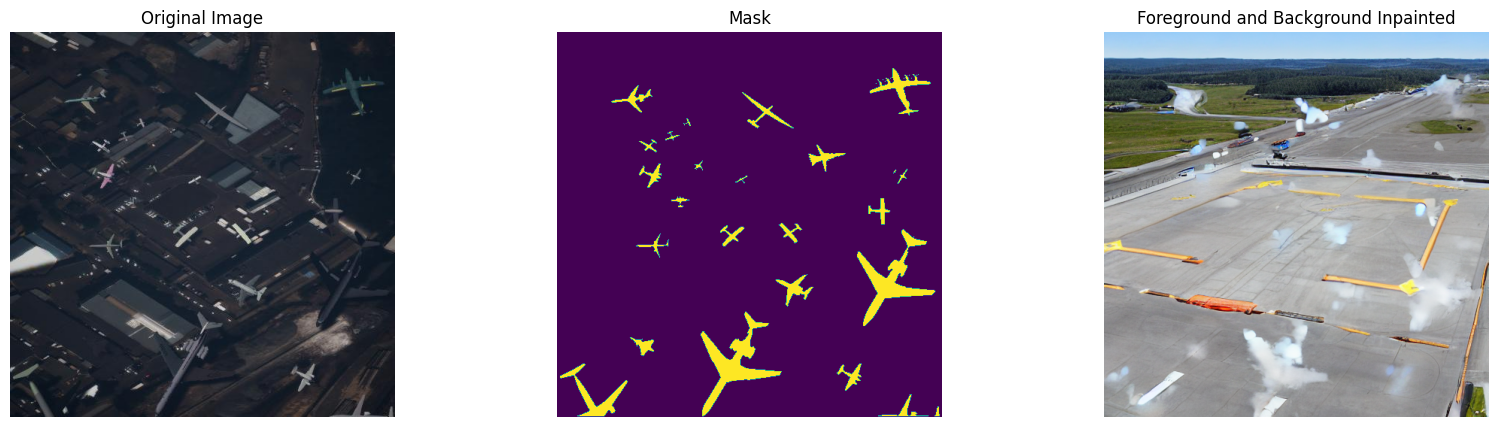

In [ ]:
# A second Testing Example to Ensure the Code Runs as intended. Loads the trained custom Stable Diffusion Inpaint Pipeline, acquires the Image and Masks,
# Prompts the User for Foreground Size and Color and Background Value, and generates the Real Image, Masked Image, and the new Synthetic Image based on the user input in the prompts.
#################### RUN THIS CODE AND FOLLOW THE PROMPTS

# Load the pipeline
pipeline = StableDiffusionInpaintPipeline.from_pretrained(
    "sd-satellite-airplanes",
    torch_dtype=torch.float16
).to("cuda")

# Load the images and masks
def get_img_and_masks(idx, create_room=False):
    coco = COCO('./data/synthetic_train_coco.json')
    img_dir = './data/synthetic_train'
    image_id = idx

    # Load image info
    img_info = coco.loadImgs(image_id)[0]

    # Load image
    init_image = np.array(Image.open(os.path.join(img_dir, img_info['file_name'])))

    # Load annotations
    ann_ids = coco.getAnnIds(imgIds=img_info['id'], iscrowd=None)
    anns = coco.loadAnns(ann_ids)

    # Initialize mask image
    mask_image = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)

    # Aggregate masks
    for ann in anns:
        mask_image += coco.annToMask(ann)

    # Ensure mask is binary
    mask_image = np.clip(mask_image, 0, 1) * 255

    # Create room around objects if specified
    if create_room:
        # Implement room creation
        shift_val = 5
        inv_mask = mask_image.copy()
        inv_mask += np.roll(mask_image, shift_val, axis=0)  # Translate the mask 5 pixels to the bottom
        inv_mask += np.roll(mask_image, -shift_val, axis=0)  # Translate the mask 5 pixels to the top
        inv_mask += np.roll(mask_image, shift_val, axis=1)  # Translate the mask 5 pixels to the right
        inv_mask += np.roll(mask_image, -shift_val, axis=1)  # Translate the mask 5 pixels to the left
        inv_mask = np.clip(inv_mask, 0, 1) * 255
        inv_mask = np.uint8(np.where(inv_mask > 0, 0, 1))

    else:
        inv_mask = np.uint8(np.where(mask_image > 0, 0, 1))

    return init_image, mask_image, inv_mask

#Display the images
def display_images(images, titles):
    fig, ax = plt.subplots(1, len(images), figsize=(20, 5))
    for i, (img, title) in enumerate(zip(images, titles)):
        ax[i].imshow(img)
        ax[i].set_title(title)
        ax[i].axis('off')
    plt.show()

# User input for prompts
foreground_size = input("Enter the size for the airplane (e.g., 'large, small, long, short, etc'): ")
foreground_color = input("Enter the color of the airplane wings (e.g., 'blue, red, yellow, black, etc'): ")
background_value = input("Enter a description for the background (e.g., 'urban, snow, forest, etc'): ")

# Construct prompts using placeholders
foreground_prompt = f"A {foreground_size} airplane high resolution as viewed from a satellite with {foreground_color} wings."
background_prompt = f"High resolution {background_value} as viewed from a satellite."

# Single image with both foreground and background
idx = 1  # Replace with the desired image index

# Load image and masks
img, mask, inv_mask = get_img_and_masks(idx)

# Generate foreground image
generated_foreground_image = pipeline(prompt=foreground_prompt, image=img, mask_image=mask).images[0]

# Generate background image using the foreground image
generated_background_image = pipeline(prompt=background_prompt, image=generated_foreground_image, mask_image=inv_mask).images[0]

# Display images: Original image, mask, and final inpainted image
display_images([img, mask, generated_background_image],
                ['Original Image', 'Mask', 'Foreground and Background Inpainted'])


##Data Setup

In [ ]:
# Total amount of images is 8,535
# Images are split into 70/30 Train and Test Images

# Directories containing images
synthetic_images_dir = './data/synthetic_train'
train_images_dir = './data/real_train'
test_images_dir = './data/real_test'

# Function to count the number of images in a directory
def count_images(image_dir):
    image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif')
    return len([file for file in os.listdir(image_dir) if file.lower().endswith(image_extensions)])

# Count images in each directory
num_synthetic_images = count_images(synthetic_images_dir)
num_train_images = count_images(train_images_dir)
num_test_images = count_images(test_images_dir)

print(f'Number of synthetic images: {num_synthetic_images}')
print(f'Number of train images: {num_train_images}')
print(f'Number of test images: {num_test_images}')


Number of synthetic images: 2000
Number of train images: 5825
Number of test images: 2710


In [ ]:
# Display Image Grid Function

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

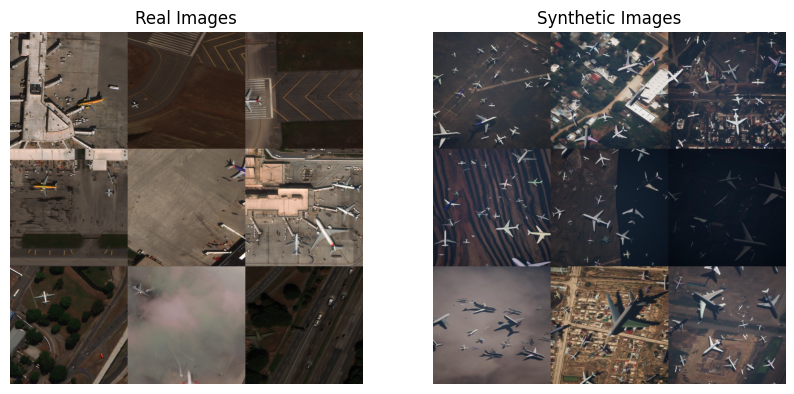

In [ ]:
# View Images using Image Grid

# Directories containing images
synthetic_images_dir = './data/synthetic_train'
train_images_dir = './data/real_train'

# Function to load a random subset of images
def load_images(image_dir, image_list, num_images):
    selected_images = random.sample(image_list, num_images)
    images = [Image.open(os.path.join(image_dir, img)) for img in selected_images]
    return images

# Ensure ".DS_Store" is removed if present
def clean_file_list(file_list):
    try:
        file_list.remove(".DS_Store")
    except ValueError:
        pass

# Load a subset of images
num_images = 9  # Define the number of images to display in the grid
rows, cols = 3, 3  # Define the grid dimensions

# Load real images
train_images = os.listdir(train_images_dir)
clean_file_list(train_images)
train_images_subset = load_images(train_images_dir, train_images, num_images)

# Load synthetic images
synthetic_images = os.listdir(synthetic_images_dir)
clean_file_list(synthetic_images)
synthetic_images_subset = load_images(synthetic_images_dir, synthetic_images, num_images)

# Create the image grid for real images
real_images_grid = image_grid(train_images_subset, rows, cols)

# Create the image grid for synthetic images
synthetic_images_grid = image_grid(synthetic_images_subset, rows, cols)

# Display the grids
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.title("Real Images")
plt.imshow(real_images_grid)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Synthetic Images")
plt.imshow(synthetic_images_grid)
plt.axis('off')

plt.show()


In [ ]:
# Load Images and Masks Function

def get_img_and_masks(idx, create_room=False):
    coco = COCO('./data/synthetic_train_coco.json')
    img_dir = './data/synthetic_train'
    image_id = idx

    # Load image info
    img_info = coco.loadImgs(image_id)[0]

    # Load image
    init_image = np.array(Image.open(os.path.join(img_dir, img_info['file_name'])))

    # Load annotations
    ann_ids = coco.getAnnIds(imgIds=img_info['id'], iscrowd=None)
    anns = coco.loadAnns(ann_ids)

    # Initialize mask image
    mask_image = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)

    # Aggregate masks
    for ann in anns:
        mask_image += coco.annToMask(ann)

    # Ensure mask is binary
    mask_image = np.clip(mask_image, 0, 1) * 255

    # Create room around objects if specified
    if create_room:
        # Implement room creation
        shift_val = 5
        inv_mask = mask_image.copy()
        inv_mask += np.roll(mask_image, shift_val, axis=0)  # Translate the mask 5 pixels to the bottom
        inv_mask += np.roll(mask_image, -shift_val, axis=0)  # Translate the mask 5 pixels to the top
        inv_mask += np.roll(mask_image, shift_val, axis=1)  # Translate the mask 5 pixels to the right
        inv_mask += np.roll(mask_image, -shift_val, axis=1)  # Translate the mask 5 pixels to the left
        inv_mask = np.clip(inv_mask, 0, 1) * 255
        inv_mask = np.uint8(np.where(inv_mask > 0, 0, 1))

    else:
        inv_mask = np.uint8(np.where(mask_image > 0, 0, 1))

    return init_image, mask_image, inv_mask

##Stable Diffusion Inpainting Pipeline

In [ ]:
#Initialize pre-trained Stable Diffusion Inpainting Pipeline

pipeline = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    torch_dtype=torch.float16
)
pipeline = pipeline.to("cuda")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
safety_checker/model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/51388a731f57604945fddd703ecb5c50e8e7b49d/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/51388a731f57604945fddd703ecb5c50e8e7b49d/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/51388a731f57604945fddd703ecb5c50e8e7b49d/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/51388a731f57604945fddd703ecb5c50e8e7b49d/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


loading annotations into memory...
Done (t=1.98s)
creating index...
index created!


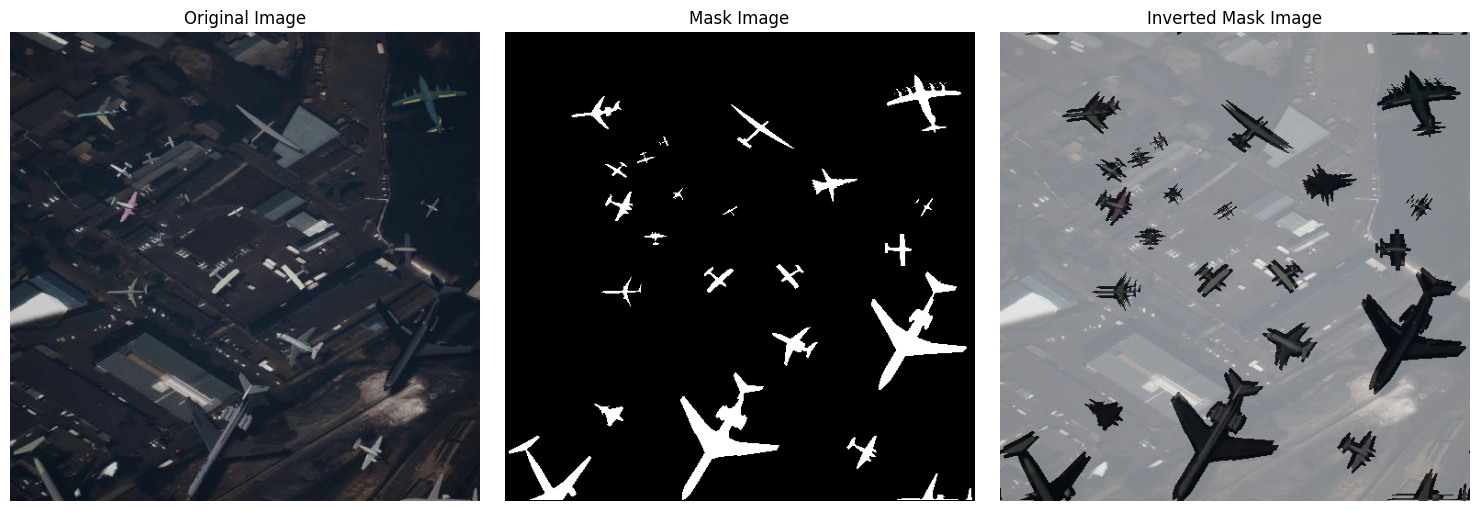

In [ ]:
# Display Real Image, Masked Image, and Inverted Mask Image

def get_img_and_masks(idx, create_room=False):
    coco = COCO('./data/synthetic_train_coco.json')
    img_dir = './data/synthetic_train'
    image_id = idx

    # Load image info
    img_info = coco.loadImgs(image_id)[0]

    # Load image
    init_image = np.array(Image.open(os.path.join(img_dir, img_info['file_name'])))

    # Load annotations
    ann_ids = coco.getAnnIds(imgIds=img_info['id'], iscrowd=None)
    anns = coco.loadAnns(ann_ids)

    # Initialize mask image
    mask_image = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)

    # Aggregate masks
    for ann in anns:
        mask_image += coco.annToMask(ann)

    # Ensure mask is binary
    mask_image = np.clip(mask_image, 0, 1) * 255

    # Create room around objects if specified
    if create_room:
        shift_val = 5
        inv_mask = mask_image.copy()
        inv_mask += np.roll(mask_image, shift_val, axis=0)  # Translate the mask 5 pixels to the bottom
        inv_mask += np.roll(mask_image, -shift_val, axis=0)  # Translate the mask 5 pixels to the top
        inv_mask += np.roll(mask_image, shift_val, axis=1)  # Translate the mask 5 pixels to the right
        inv_mask += np.roll(mask_image, -shift_val, axis=1)  # Translate the mask 5 pixels to the left
        inv_mask = np.clip(inv_mask, 0, 1) * 255
        inv_mask = np.uint8(np.where(inv_mask > 0, 0, 1))

    else:
        inv_mask = np.uint8(np.where(mask_image > 0, 0, 1))

    return init_image, mask_image, inv_mask

# Use the function and display the result
idx = 1  # Example image index
init_image, mask_image, inv_mask = get_img_and_masks(idx, create_room=True)

# Plotting the results
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(init_image)
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(mask_image, cmap='gray')
ax[1].set_title('Mask Image')
ax[1].axis('off')

ax[2].imshow(init_image)
ax[2].imshow(inv_mask, cmap='gray', alpha=0.5)
ax[2].set_title('Inverted Mask Image')
ax[2].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Generates 1000 Synthetic Images Using Custom Random Prompts for Foreground and Background

random.seed(1447)

num_images_to_generate = 1000
synthetic_images_dir = './data/synthetic_train'
synthetic_images = os.listdir("./data/synthetic_train")
try:
  synthetic_images.remove(".DS_Store")
except:
  pass

train_images_dir = './data/real_train'
train_images = os.listdir("./data/real_train")
try:
  train_images.remove(".DS_Store")
except:
  pass

num_synthetic_images = len(synthetic_images)
num_train_images = len(train_images)

train_images_idx = random.sample(list(range(num_train_images)), num_images_to_generate)
synthetic_images_idx = random.sample(list(range(num_synthetic_images)), num_images_to_generate)

#################
# Get real images
#################
if not os.path.exists("./data/vanilla_realImgs.pt"):
    real_images = []
    for idx in train_images_idx:
      image = torch.tensor(np.array(Image.open(os.path.join(train_images_dir, train_images[idx]))))[None,...]
      real_images.append(image)
    real_images = torch.cat(real_images,dim=0).permute(0,3,1,2)
    torch.save(real_images, "./data/vanilla_realImgs.pt")
else:
    print("Loading real images ...")
    real_images = torch.load("./data/vanilla_realImgs.pt")

print(f"Shape of real images tensor is: {real_images.shape}")

#################################
# Get processed synthetic images.
#################################
if not os.path.exists("./data/vanilla_fakeImgs.pt"):
    color = ["red","green","blue","white","black","orange"]
    size = ["Long","Short","Big","Small","Large"]
    bg = ["desert", "himalayan snow", "forest", "arabian sea"]
    bg_or_fg = ["bg","fg"]
    vanilla_prompts = []
    fake_images = []
    fake_images_org = []
    for enumix, idx in enumerate(synthetic_images_idx):
      b_or_f = random.choice(bg_or_fg)
      print(f"Processing Image: {enumix}")
      if b_or_f == "fg":
        s = random.choice(size)
        c = random.choice(color)
        prompt = f"{s} airplanes high resolution as viewed from a satellite with {c} wings."
        img, mask, inv_mask = get_img_and_masks(idx)
        fake_images.append(torch.tensor(np.asarray(pipeline(prompt=prompt, image=img, mask_image=mask).images[0]))[None,...])
        fake_images_org.append(torch.tensor(img)[None,...])
      else:
        b = random.choice(bg)
        prompt = f"High resolution {b} as viewed from a satellite."
        img, mask, inv_mask = get_img_and_masks(idx, create_room=True)
        fake_images_org.append(torch.tensor(img)[None,...])
        fake_images.append(torch.tensor(np.asarray(pipeline(prompt=prompt, image=img, mask_image=inv_mask).images[0]))[None,...])

      vanilla_prompts.append(prompt+"\n")

    fake_images = torch.cat(fake_images,dim=0).permute(0,3,1,2).cpu()
    fake_images_org = torch.cat(fake_images_org,dim=0).permute(0,3,1,2).cpu()
    torch.save(fake_images, "./data/vanilla_fakeImgs.pt")
    torch.save(fake_images_org, "./data/vanilla_fakeImgs_org.pt")
    with open("./data/vanilla_prompts.txt","w") as f:
        f.writelines(vanilla_prompts)
else:
    print("Loading fake images ...")
    fake_images = torch.load("./data/vanilla_fakeImgs.pt")
    fake_images_org = torch.load("./data/vanilla_fakeImgs_org.pt")
    with open("./data/vanilla_prompts.txt","r") as f:
        vanilla_prompts = f.readlines()

print(f"Shape of fake org images tensor is: {fake_images_org.shape}")
print(f"Shape of fake images tensor is: {fake_images.shape}")

Loading real images ...
Shape of real images tensor is: torch.Size([1000, 3, 512, 512])
Loading fake images ...
Shape of fake org images tensor is: torch.Size([1000, 3, 512, 512])
Shape of fake images tensor is: torch.Size([1000, 3, 512, 512])


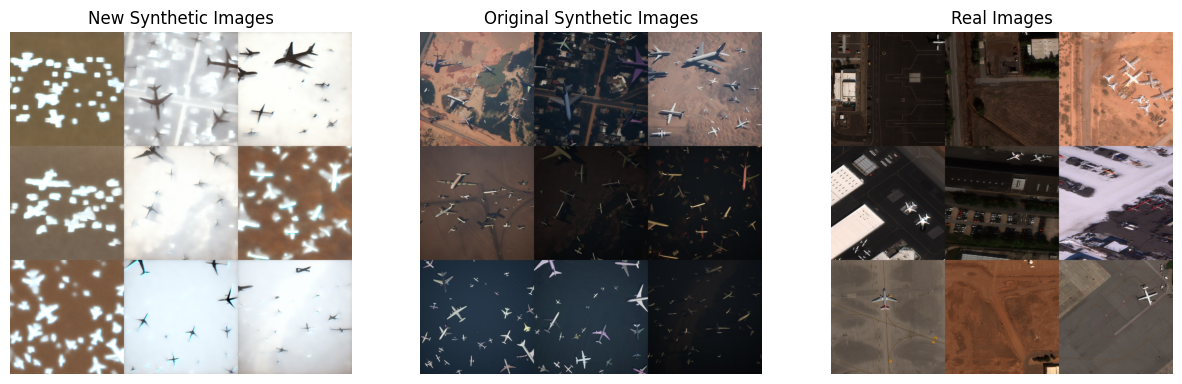

In [ ]:
# Display a random subset of newly created Synthetic Images, along with the Original (manually done) Synthetic Images and the Real Images

# Function to convert a tensor to a list of PIL images
def tensor_to_pil_images(tensor, num_images):
    images = []
    for i in range(num_images):
        img_array = tensor[i].permute(1, 2, 0).cpu().numpy().astype(np.uint8)
        img = Image.fromarray(img_array)
        images.append(img)
    return images

# Load the tensors
vanilla_fakeImgs = torch.load('./data/vanilla_fakeImgs.pt')
vanilla_fakeImgs_org = torch.load('./data/vanilla_fakeImgs_org.pt')
vanilla_realImgs = torch.load('./data/vanilla_realImgs.pt')

# Number of images to display in the grid
num_images = 9
rows, cols = 3, 3

# Convert tensors to PIL images
fake_images = tensor_to_pil_images(vanilla_fakeImgs, num_images)
fake_org_images = tensor_to_pil_images(vanilla_fakeImgs_org, num_images)
real_images = tensor_to_pil_images(vanilla_realImgs, num_images)

# Create the image grids
fake_images_grid = image_grid(fake_images, rows, cols)
fake_org_images_grid = image_grid(fake_org_images, rows, cols)
real_images_grid = image_grid(real_images, rows, cols)

# Display the grids
plt.figure(figsize=(15, 15))

plt.subplot(1, 3, 1)
plt.title("New Synthetic Images")
plt.imshow(fake_images_grid)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Original Synthetic Images")
plt.imshow(fake_org_images_grid)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Real Images")
plt.imshow(real_images_grid)
plt.axis('off')

plt.show()

In [ ]:
# Determine Performance Metric - Description: FID measures the distance between the feature distributions of real and generated images.
# It uses a pre-trained Inception network to extract features and then compares the mean and covariance of these features.

# Load tensors from .pt files
vanilla_fakeImgs = torch.load('./data/vanilla_fakeImgs.pt')
vanilla_fakeImgs_org = torch.load('./data/vanilla_fakeImgs_org.pt')
vanilla_realImgs = torch.load('./data/vanilla_realImgs.pt')

# Function to update FID in batches
def update_fid_in_batches(fid_metric, real_images, fake_images, batch_size=64):
    num_batches = len(real_images) // batch_size
    for i in range(num_batches + 1):
        real_batch = real_images[i * batch_size:(i + 1) * batch_size].cuda()
        fake_batch = fake_images[i * batch_size:(i + 1) * batch_size].cuda()
        if len(real_batch) > 0:
            fid_metric.update(real_batch, real=True)
        if len(fake_batch) > 0:
            fid_metric.update(fake_batch, real=False)

# Calculate FID for synthetic images
fid_metric = FrechetInceptionDistance(normalize=True).cuda()  # Ensure to use CUDA if available
update_fid_in_batches(fid_metric, vanilla_realImgs, vanilla_fakeImgs)
fid_fake = fid_metric.compute()
print(f'FID score for synthetic images: {fid_fake.item()}')

# Reset the metric for the next calculation
fid_metric.reset()

# Calculate FID for original synthetic images
update_fid_in_batches(fid_metric, vanilla_realImgs, vanilla_fakeImgs_org)
fid_fake_org = fid_metric.compute()
print(f'FID score for original synthetic images: {fid_fake_org.item()}')

FID score for synthetic images: 292.3679504394531
FID score for original synthetic images: 184.79808044433594


##Stable Diffusion Fine-Tuning (Textual Inversion) Pipeline

In [ ]:
# Set up the images to be used for Textual Inversion and display them.

if not os.path.exists("./data/aircraft_textinversion_images"):
  !mkdir ./data/aircraft_textinversion_images

!cp "./data/real_train/100_1040010046CD1500_tile_476.png" "./data/aircraft_textinversion_images/"
!cp "./data/real_train/100_1040010046CD1500_tile_525.png" "./data/aircraft_textinversion_images/"
!cp "./data/real_train/102_104001003D82DC00_tile_56.png" "./data/aircraft_textinversion_images/"
!cp "./data/real_train/105_104001002F92BB00_tile_86.png" "./data/aircraft_textinversion_images/"
!cp "./data/real_train/106_1040010044D30600_tile_110.png" "./data/aircraft_textinversion_images/"
!cp "./data/real_train/113_10400100413CDF00_tile_167.png" "./data/aircraft_textinversion_images/"
!cp "./data/real_train/114_104001000A497900_tile_194.png" "./data/aircraft_textinversion_images/"
!cp "./data/real_train/127_1040010022BC3B00_tile_535.png" "./data/aircraft_textinversion_images/"
!cp "./data/real_train/100_1040010039437200_tile_569.png" "./data/aircraft_textinversion_images/"
!cp "./data/real_train/127_1040010022BC3B00_tile_513.png" "./data/aircraft_textinversion_images/"
!cp "./data/real_train/4_10400100360CD600_tile_817.png" "./data/aircraft_textinversion_images/"
!cp "./data/real_train/96_10400100096C2500_tile_325.png" "./data/aircraft_textinversion_images/"
!cp "./data/real_train/96_10400100096C2500_tile_1185.png" "./data/aircraft_textinversion_images/"
!cp "./data/real_train/87_10400100480E4300_tile_30.png" "./data/aircraft_textinversion_images/"
!cp "./data/real_train/54_1040010042D13B00_tile_616.png" "./data/aircraft_textinversion_images/"
!cp "./data/real_train/37_104001000EA43C00_tile_247.png" "./data/aircraft_textinversion_images/"
!cp "./data/real_train/52_1040010039815D00_tile_467.png" "./data/aircraft_textinversion_images/"
!cp "./data/real_train/54_1040010024086400_tile_702.png" "./data/aircraft_textinversion_images/"
!cp "./data/real_train/57_10400100379F8200_tile_397.png" "./data/aircraft_textinversion_images/"
!cp "./data/real_train/66_1040010037570000_tile_49.png" "./data/aircraft_textinversion_images/"

save_path = "./data/aircraft_textinversion_images"

images = []
for file_path in os.listdir(save_path):
  try:
      image_path = os.path.join(save_path, file_path)
      images.append(Image.open(image_path).resize((512, 512)))
  except:
    print(f"{image_path} is not a valid image, please make sure to remove this file from the directory otherwise the training could fail.")
image_grid(images, 4, 5)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Set up Training Parameters for the Fine-Tuning

pretrained_model_name_or_path = "runwayml/stable-diffusion-v1-5"
what_to_teach = "object"
placeholder_token = "\u003Csatellite-airplanes>"
initializer_token = "airplanes"

imagenet_templates_small = [
    "a photo of a {}",
    "a rendering of a {}",
    "a cropped photo of the {}",
    "the photo of a {}",
    "a photo of a clean {}",
    "a photo of a dirty {}",
    "a dark photo of the {}",
    "a photo of my {}",
    "a photo of the cool {}",
    "a close-up photo of a {}",
    "a bright photo of the {}",
    "a cropped photo of a {}",
    "a photo of the {}",
    "a good photo of the {}",
    "a photo of one {}",
    "a close-up photo of the {}",
    "a rendition of the {}",
    "a photo of the clean {}",
    "a rendition of a {}",
    "a photo of a nice {}",
    "a good photo of a {}",
    "a photo of the nice {}",
    "a photo of the small {}",
    "a photo of the weird {}",
    "a photo of the large {}",
    "a photo of a cool {}",
    "a photo of a small {}",
]

In [ ]:
# Create a Torch Dataset Class to Load the Data

class TextualInversionDataset(Dataset):
    def __init__(
        self,
        data_root,
        tokenizer,
        learnable_property="object",  # [object, style]
        size=512,
        repeats=100,
        interpolation="bicubic",
        flip_p=0.5,
        set="train",
        placeholder_token="*",
        center_crop=False,
    ):

        self.data_root = data_root
        self.tokenizer = tokenizer
        self.learnable_property = learnable_property
        self.size = size
        self.placeholder_token = placeholder_token
        self.center_crop = center_crop
        self.flip_p = flip_p

        self.image_paths = [os.path.join(self.data_root, file_path) for file_path in os.listdir(self.data_root)]

        self.num_images = len(self.image_paths)
        self._length = self.num_images

        if set == "train":
            self._length = self.num_images * repeats

        self.interpolation = {
            "linear": PIL.Image.LINEAR,
            "bilinear": PIL.Image.BILINEAR,
            "bicubic": PIL.Image.BICUBIC,
            "lanczos": PIL.Image.LANCZOS,
        }[interpolation]

        self.templates = imagenet_style_templates_small if learnable_property == "style" else imagenet_templates_small
        self.flip_transform = transforms.RandomHorizontalFlip(p=self.flip_p)

    def __len__(self):
        return self._length

    def __getitem__(self, i):
        example = {}
        image = Image.open(self.image_paths[i % self.num_images])

        if not image.mode == "RGB":
            image = image.convert("RGB")

        placeholder_string = self.placeholder_token
        text = random.choice(self.templates).format(placeholder_string)

        example["input_ids"] = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
            return_tensors="pt",
        ).input_ids[0]

        # default to score-sde preprocessing
        img = np.array(image).astype(np.uint8)

        if self.center_crop:
            crop = min(img.shape[0], img.shape[1])
            h, w, = (
                img.shape[0],
                img.shape[1],
            )
            img = img[(h - crop) // 2 : (h + crop) // 2, (w - crop) // 2 : (w + crop) // 2]

        image = Image.fromarray(img)
        image = image.resize((self.size, self.size), resample=self.interpolation)

        image = self.flip_transform(image)
        image = np.array(image).astype(np.uint8)
        image = (image / 127.5 - 1.0).astype(np.float32)

        example["pixel_values"] = torch.from_numpy(image).permute(2, 0, 1)
        return example

In [ ]:
# Load the Tokenizer and Add the Placeholder Token as an Additional Special Token

tokenizer = CLIPTokenizer.from_pretrained(
    pretrained_model_name_or_path,
    subfolder="tokenizer",
)

# Add the placeholder token in tokenizer
num_added_tokens = tokenizer.add_tokens(placeholder_token)
if num_added_tokens == 0:
    raise ValueError(
        f"The tokenizer already contains the token {placeholder_token}. Please pass a different"
        " `placeholder_token` that is not already in the tokenizer."
    )

In [ ]:
# Get Token IDs for the Placeholder and Initializer Token

# Convert the initializer_token, placeholder_token to ids
token_ids = tokenizer.encode(initializer_token, add_special_tokens=False)
# Check if initializer_token is a single token or a sequence of tokens
if len(token_ids) > 1:
    raise ValueError("The initializer token must be a single token.")

initializer_token_id = token_ids[0]
placeholder_token_id = tokenizer.convert_tokens_to_ids(placeholder_token)

In [ ]:
# Load the Text Encoder, VAE, and Unet

text_encoder = CLIPTextModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="text_encoder"
)
vae = AutoencoderKL.from_pretrained(
    pretrained_model_name_or_path, subfolder="vae"
)
unet = UNet2DConditionModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="unet"
)

In [ ]:
# Resize Text Encoder

text_encoder.resize_token_embeddings(len(tokenizer))

Embedding(49409, 768)

In [ ]:
# Assign Input Embeddings to Token Embeds

token_embeds = text_encoder.get_input_embeddings().weight.data
token_embeds[placeholder_token_id] = token_embeds[initializer_token_id]

In [ ]:
# Create Train Dataset and Scheduler. Freeze VAE and Unet parameters.

text_encoder.resize_token_embeddings(len(tokenizer))

token_embeds = text_encoder.get_input_embeddings().weight.data
token_embeds[placeholder_token_id] = token_embeds[initializer_token_id]

def freeze_params(params):
    for param in params:
        param.requires_grad = False

# Freeze vae and unet
freeze_params(vae.parameters())
freeze_params(unet.parameters())
# Freeze all parameters except for the token embeddings in text encoder
params_to_freeze = itertools.chain(
    text_encoder.text_model.encoder.parameters(),
    text_encoder.text_model.final_layer_norm.parameters(),
    text_encoder.text_model.embeddings.position_embedding.parameters(),
)
freeze_params(params_to_freeze)

train_dataset = TextualInversionDataset(
      data_root=save_path,
      tokenizer=tokenizer,
      size=vae.sample_size,
      placeholder_token=placeholder_token,
      repeats=100,
      learnable_property=what_to_teach, #Option selected above between object and style
      center_crop=False,
      set="train",
)

def create_dataloader(train_batch_size=1):
    return torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)

noise_scheduler = DDPMScheduler.from_config(pretrained_model_name_or_path, subfolder="scheduler")

<ipython-input-19-76c41112c75e>:24: FutureWarning: Accessing config attribute `sample_size` directly via 'AutoencoderKL' object attribute is deprecated. Please access 'sample_size' over 'AutoencoderKL's config object instead, e.g. 'unet.config.sample_size'.
  size=vae.sample_size,
<ipython-input-13-7ff248bb18ae>:33: DeprecationWarning: LINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use BILINEAR or Resampling.BILINEAR instead.
  "linear": PIL.Image.LINEAR,
/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:245: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddpm.DDPMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)


In [ ]:
# Set up all Training Arguments

hyperparameters = {
    "learning_rate": 5e-04,
    "scale_lr": True,
    "max_train_steps": 2000,
    "save_steps": 250,
    "train_batch_size": 4,
    "gradient_accumulation_steps": 1,
    "gradient_checkpointing": True,
    "mixed_precision": "fp16",
    "seed": 42,
    "output_dir": "sd-satellite-airplanes"
}
!mkdir -p sd-satellite-airplanes

In [ ]:
# Set up Training Function, Create the new pipeline using the trained modules and save embeddings.


logger = get_logger(__name__)

def save_progress(text_encoder, placeholder_token_id, accelerator, save_path):
    logger.info("Saving embeddings")
    learned_embeds = accelerator.unwrap_model(text_encoder).get_input_embeddings().weight[placeholder_token_id]
    learned_embeds_dict = {placeholder_token: learned_embeds.detach().cpu()}
    torch.save(learned_embeds_dict, save_path)

def training_function(text_encoder, vae, unet):
    train_batch_size = hyperparameters["train_batch_size"]
    gradient_accumulation_steps = hyperparameters["gradient_accumulation_steps"]
    learning_rate = hyperparameters["learning_rate"]
    max_train_steps = hyperparameters["max_train_steps"]
    output_dir = hyperparameters["output_dir"]
    gradient_checkpointing = hyperparameters["gradient_checkpointing"]

    accelerator = Accelerator(
        gradient_accumulation_steps=gradient_accumulation_steps,
        mixed_precision=hyperparameters["mixed_precision"]
    )

    if gradient_checkpointing:
        text_encoder.gradient_checkpointing_enable()
        unet.enable_gradient_checkpointing()

    train_dataloader = create_dataloader(train_batch_size)

    if hyperparameters["scale_lr"]:
        learning_rate = (
            learning_rate * gradient_accumulation_steps * train_batch_size * accelerator.num_processes
        )

    # Initialize the optimizer
    optimizer = torch.optim.AdamW(
        text_encoder.get_input_embeddings().parameters(),  # only optimize the embeddings
        lr=learning_rate,
    )

    text_encoder, optimizer, train_dataloader = accelerator.prepare(
        text_encoder, optimizer, train_dataloader
    )

    weight_dtype = torch.float32
    if accelerator.mixed_precision == "fp16":
        weight_dtype = torch.float16
    elif accelerator.mixed_precision == "bf16":
        weight_dtype = torch.bfloat16

    # Move vae and unet to device
    vae.to(accelerator.device, dtype=weight_dtype)
    unet.to(accelerator.device, dtype=weight_dtype)

    # Keep vae in eval mode as we don't train it
    vae.eval()
    # Keep unet in train mode to enable gradient checkpointing
    unet.train()


    # We need to recalculate our total training steps as the size of the training dataloader may have changed.
    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / gradient_accumulation_steps)
    num_train_epochs = math.ceil(max_train_steps / num_update_steps_per_epoch)

    # Train!
    total_batch_size = train_batch_size * accelerator.num_processes * gradient_accumulation_steps

    logger.info("***** Running training *****")
    logger.info(f"  Num examples = {len(train_dataset)}")
    logger.info(f"  Instantaneous batch size per device = {train_batch_size}")
    logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
    logger.info(f"  Gradient Accumulation steps = {gradient_accumulation_steps}")
    logger.info(f"  Total optimization steps = {max_train_steps}")
    # Only show the progress bar once on each machine.
    progress_bar = tqdm(range(max_train_steps), disable=not accelerator.is_local_main_process)
    progress_bar.set_description("Steps")
    global_step = 0

    for epoch in range(num_train_epochs):
        text_encoder.train()
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(text_encoder):
                # Convert images to latent space
                latents = vae.encode(batch["pixel_values"].to(dtype=weight_dtype)).latent_dist.sample().detach()
                latents = latents * 0.18215

                # Sample noise that we'll add to the latents
                noise = torch.randn_like(latents)
                bsz = latents.shape[0]
                # Sample a random timestep for each image
                timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bsz,), device=latents.device).long()

                # Add noise to the latents according to the noise magnitude at each timestep
                # (this is the forward diffusion process)
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # Get the text embedding for conditioning
                encoder_hidden_states = text_encoder(batch["input_ids"])[0]

                # Predict the noise residual
                noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states.to(weight_dtype)).sample

                 # Get the target for loss depending on the prediction type
                if noise_scheduler.config.prediction_type == "epsilon":
                    target = noise
                elif noise_scheduler.config.prediction_type == "v_prediction":
                    target = noise_scheduler.get_velocity(latents, noise, timesteps)
                else:
                    raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")

                loss = F.mse_loss(noise_pred, target, reduction="none").mean([1, 2, 3]).mean()
                accelerator.backward(loss)

                # Zero out the gradients for all token embeddings except the newly added
                # embeddings for the concept, as we only want to optimize the concept embeddings
                if accelerator.num_processes > 1:
                    grads = text_encoder.module.get_input_embeddings().weight.grad
                else:
                    grads = text_encoder.get_input_embeddings().weight.grad
                # Get the index for tokens that we want to zero the grads for
                index_grads_to_zero = torch.arange(len(tokenizer)) != placeholder_token_id
                grads.data[index_grads_to_zero, :] = grads.data[index_grads_to_zero, :].fill_(0)

                optimizer.step()
                optimizer.zero_grad()

            # Checks if the accelerator has performed an optimization step behind the scenes
            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1
                if global_step % hyperparameters["save_steps"] == 0:
                    save_path = os.path.join(output_dir, f"learned_embeds-step-{global_step}.bin")
                    save_progress(text_encoder, placeholder_token_id, accelerator, save_path)

            logs = {"loss": loss.detach().item()}
            progress_bar.set_postfix(**logs)

            if global_step >= max_train_steps:
                break

        accelerator.wait_for_everyone()


    # Create the pipeline using using the trained modules and save it.
    if accelerator.is_main_process:
        pipeline = StableDiffusionPipeline.from_pretrained(
            pretrained_model_name_or_path,
            text_encoder=accelerator.unwrap_model(text_encoder),
            tokenizer=tokenizer,
            vae=vae,
            unet=unet,
        )
        pipeline.save_pretrained(output_dir)
        # Also save the newly trained embeddings
        save_path = os.path.join(output_dir, f"learned_embeds.bin")
        save_progress(text_encoder, placeholder_token_id, accelerator, save_path)

In [ ]:
# Train the diffusion model and save to drive

accelerate.notebook_launcher(training_function, args=(text_encoder, vae, unet))

for param in itertools.chain(unet.parameters(), text_encoder.parameters()):
  if param.grad is not None:
    del param.grad  # free some memory
  torch.cuda.empty_cache()

Launching training on one GPU.


  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
# Set up Stable Diffusion Inpaint Pipeline with new Trained Model

pipeline = StableDiffusionInpaintPipeline.from_pretrained(
    "sd-satellite-airplanes",
    torch_dtype=torch.float16
)
pipeline = pipeline.to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [ ]:
# Generate 1000 synthetic images with fine tuned parameters. Added more prompt option such as urban, runway, parking apron.

random.seed(1447)

num_images_to_generate = 1000
synthetic_images_dir = './data/synthetic_train'
synthetic_images = os.listdir("./data/synthetic_train")
try:
  synthetic_images.remove(".DS_Store")
except:
  pass

train_images_dir = './data/real_train'
train_images = os.listdir("./data/real_train")
try:
  train_images.remove(".DS_Store")
except:
  pass

num_synthetic_images = len(synthetic_images)
num_train_images = len(train_images)

train_images_idx = random.sample(list(range(num_train_images)), num_images_to_generate)
synthetic_images_idx = random.sample(list(range(num_synthetic_images)), num_images_to_generate)

#################
# Get real images
#################
if not os.path.exists("./data/finetuned1_realImgs.pt"):
    real_images = []
    for idx in train_images_idx:
      image = torch.tensor(np.array(Image.open(os.path.join(train_images_dir, train_images[idx]))))[None,...]
      real_images.append(image)
    real_images = torch.cat(real_images,dim=0).permute(0,3,1,2)
    torch.save(real_images, "./data/finetuned1_realImgs.pt")
else:
    print("Loading real images ...")
    real_images = torch.load("./data/finetuned1_realImgs.pt")

print(f"Shape of real images tensor is: {real_images.shape}")

#################################
# Get processed synthetic images.
#################################
if not os.path.exists("./data/finetuned1_fakeImgs.pt"):
    color = ["red","green","blue","white","black","orange"]
    size = ["Long","Short","Big","Small","Large"]
    bg = ["desert", "himalayan snow", "forest", "arabian sea", "urban", "runway", "parking apron"]
    bg_or_fg = ["bg","fg"]
    vanilla_prompts = []
    fake_images = []
    fake_images_org = []
    for enumix, idx in enumerate(synthetic_images_idx):
      b_or_f = random.choice(bg_or_fg)
      print(f"Processing Image: {enumix}")
      if b_or_f == "fg":
        s = random.choice(size)
        c = random.choice(color)
        prompt = f"{s} airplanes high resolution as viewed from a satellite with {c} wings."
        img, mask, inv_mask = get_img_and_masks(idx)
        fake_images.append(torch.tensor(np.asarray(pipeline(prompt=prompt, image=img, mask_image=mask).images[0]))[None,...])
        fake_images_org.append(torch.tensor(img)[None,...])
      else:
        b = random.choice(bg)
        prompt = f"High resolution {b} as viewed from a satellite."
        img, mask, inv_mask = get_img_and_masks(idx, create_room=True)
        fake_images_org.append(torch.tensor(img)[None,...])
        fake_images.append(torch.tensor(np.asarray(pipeline(prompt=prompt, image=img, mask_image=inv_mask).images[0]))[None,...])

      vanilla_prompts.append(prompt+"\n")

    fake_images = torch.cat(fake_images,dim=0).permute(0,3,1,2).cpu()
    fake_images_org = torch.cat(fake_images_org,dim=0).permute(0,3,1,2).cpu()
    torch.save(fake_images, "./data/finetuned1_fakeImgs.pt")
    torch.save(fake_images_org, "./data/finetuned1_fakeImgs_org.pt")
    with open("./data/finetuned1_prompts.txt","w") as f:
        f.writelines(vanilla_prompts)
else:
    print("Loading fake images ...")
    fake_images = torch.load("./data/finetuned1_fakeImgs.pt")
    fake_images_org = torch.load("./data/finetuned1_fakeImgs_org.pt")
    with open("./data/finetuned1_prompts.txt","r") as f:
        vanilla_prompts = f.readlines()

print(f"Shape of fake org images tensor is: {fake_images_org.shape}")
print(f"Shape of fake images tensor is: {fake_images.shape}")

Loading real images ...
Shape of real images tensor is: torch.Size([1000, 3, 512, 512])
Loading fake images ...
Shape of fake org images tensor is: torch.Size([1000, 3, 512, 512])
Shape of fake images tensor is: torch.Size([1000, 3, 512, 512])


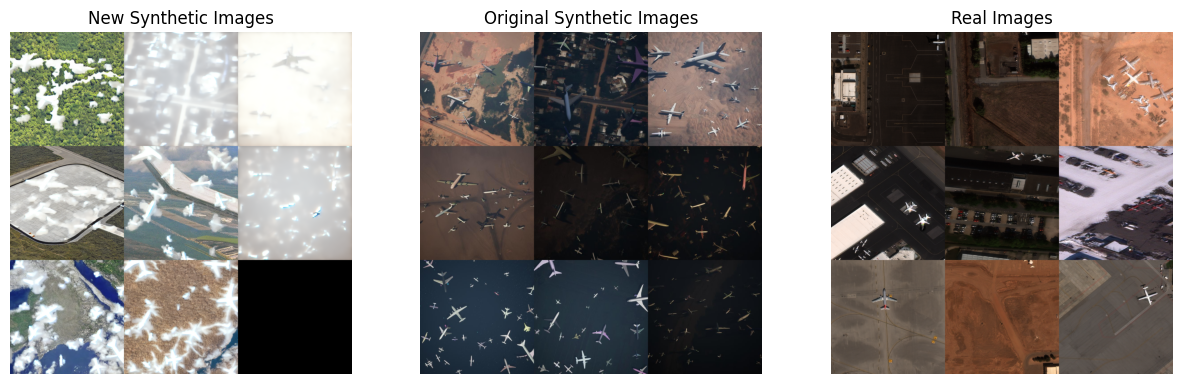

In [ ]:
# Display a random subset of the New Synthetic Images, Original Synthetic Images, and Real Images in a Grid

# Function to convert a tensor to a list of PIL images
def tensor_to_pil_images(tensor, num_images):
    images = []
    for i in range(num_images):
        img_array = tensor[i].permute(1, 2, 0).cpu().numpy().astype(np.uint8)
        img = Image.fromarray(img_array)
        images.append(img)
    return images

# Load the tensors
finetuned1_fakeImgs = torch.load('./data/finetuned1_fakeImgs.pt')
finetuned1_fakeImgs_org = torch.load('./data/finetuned1_fakeImgs_org.pt')
finetuned1_realImgs = torch.load('./data/finetuned1_realImgs.pt')

# Number of images to display in the grid
num_images = 9
rows, cols = 3, 3

# Convert tensors to PIL images
fake_images = tensor_to_pil_images(finetuned1_fakeImgs, num_images)
fake_org_images = tensor_to_pil_images(finetuned1_fakeImgs_org, num_images)
real_images = tensor_to_pil_images(finetuned1_realImgs, num_images)

# Create the image grids
fake_images_grid = image_grid(fake_images, rows, cols)
fake_org_images_grid = image_grid(fake_org_images, rows, cols)
real_images_grid = image_grid(real_images, rows, cols)

# Display the grids
plt.figure(figsize=(15, 15))

plt.subplot(1, 3, 1)
plt.title("New Synthetic Images")
plt.imshow(fake_images_grid)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Original Synthetic Images")
plt.imshow(fake_org_images_grid)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Real Images")
plt.imshow(real_images_grid)
plt.axis('off')

plt.show()

In [ ]:
# Ran same model to Generate 1000 synthetic images with fine tuned parameters. Added more prompt option such as urban, runway, parking apron, refined mask handling.

random.seed(1447)

num_images_to_generate = 1000
synthetic_images_dir = './data/synthetic_train'
synthetic_images = os.listdir("./data/synthetic_train")
try:
  synthetic_images.remove(".DS_Store")
except:
  pass

train_images_dir = './data/real_train'
train_images = os.listdir("./data/real_train")
try:
  train_images.remove(".DS_Store")
except:
  pass

num_synthetic_images = len(synthetic_images)
num_train_images = len(train_images)

train_images_idx = random.sample(list(range(num_train_images)), num_images_to_generate)
synthetic_images_idx = random.sample(list(range(num_synthetic_images)), num_images_to_generate)

#################
# Get real images
#################
if not os.path.exists("./data/finetuned2_realImgs.pt"):
    real_images = []
    for idx in train_images_idx:
      image = torch.tensor(np.array(Image.open(os.path.join(train_images_dir, train_images[idx]))))[None,...]
      real_images.append(image)
    real_images = torch.cat(real_images,dim=0).permute(0,3,1,2)
    torch.save(real_images, "./data/finetuned2_realImgs.pt")
else:
    print("Loading real images ...")
    real_images = torch.load("./data/finetuned2_realImgs.pt")

print(f"Shape of real images tensor is: {real_images.shape}")

#################################
# Get processed synthetic images.
#################################
if not os.path.exists("./data/finetuned2_fakeImgs.pt"):
    color = ["red","green","blue","white","black","orange"]
    size = ["Long","Short","Big","Small","Large"]
    bg = ["desert", "himalayan snow", "forest", "arabian sea", "urban", "runway", "parking apron"]
    bg_or_fg = ["bg","fg"]
    vanilla_prompts = []
    fake_images = []
    fake_images_org = []
    for enumix, idx in enumerate(synthetic_images_idx):
      b_or_f = random.choice(bg_or_fg)
      print(f"Processing Image: {enumix}")
      if b_or_f == "fg":
        s = random.choice(size)
        c = random.choice(color)
        prompt = f"{s} airplanes high resolution as viewed from a satellite with {c} wings."
        img, mask, inv_mask = get_img_and_masks(idx)
        fake_images.append(torch.tensor(np.asarray(pipeline(prompt=prompt, image=img, mask_image=mask).images[0]))[None,...])
        fake_images_org.append(torch.tensor(img)[None,...])
      else:
        b = random.choice(bg)
        prompt = f"High resolution {b} as viewed from a satellite."
        img, mask, inv_mask = get_img_and_masks(idx, create_room=True)
        fake_images_org.append(torch.tensor(img)[None,...])
        fake_images.append(torch.tensor(np.asarray(pipeline(prompt=prompt, image=img, mask_image=inv_mask).images[0]))[None,...])

      vanilla_prompts.append(prompt+"\n")

    fake_images = torch.cat(fake_images,dim=0).permute(0,3,1,2).cpu()
    fake_images_org = torch.cat(fake_images_org,dim=0).permute(0,3,1,2).cpu()
    torch.save(fake_images, "./data/finetuned2_fakeImgs.pt")
    torch.save(fake_images_org, "./data/finetuned2_fakeImgs_org.pt")
    with open("./data/finetuned2_prompts.txt","w") as f:
        f.writelines(vanilla_prompts)
else:
    print("Loading fake images ...")
    fake_images = torch.load("./data/finetuned2_fakeImgs.pt")
    fake_images_org = torch.load("./data/finetuned2_fakeImgs_org.pt")
    with open("./data/finetuned2_prompts.txt","r") as f:
        vanilla_prompts = f.readlines()

print(f"Shape of fake org images tensor is: {fake_images_org.shape}")
print(f"Shape of fake images tensor is: {fake_images.shape}")

Loading real images ...
Shape of real images tensor is: torch.Size([1000, 3, 512, 512])
Loading fake images ...
Shape of fake org images tensor is: torch.Size([1000, 3, 512, 512])
Shape of fake images tensor is: torch.Size([1000, 3, 512, 512])


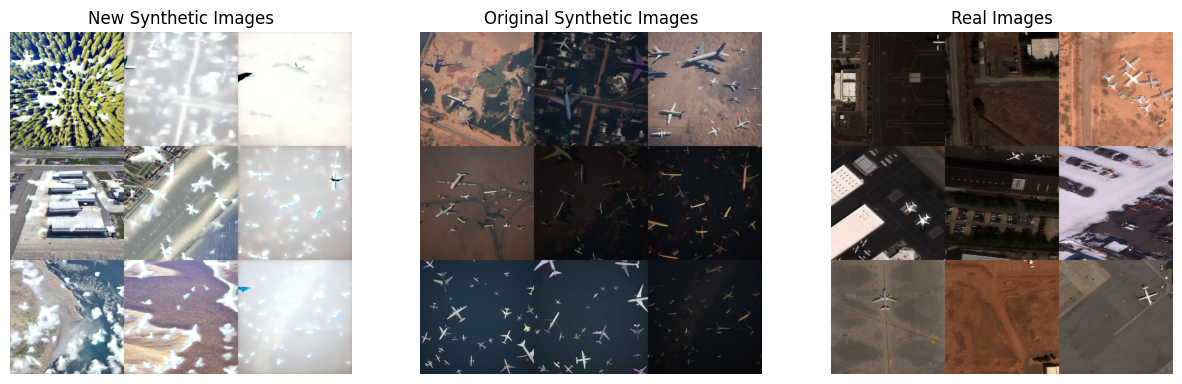

In [ ]:
# Display a random subset of the New Synthetic Images, Original Synthetic Images, and Real Images in a Grid

# Function to convert a tensor to a list of PIL images
def tensor_to_pil_images(tensor, num_images):
    images = []
    for i in range(num_images):
        img_array = tensor[i].permute(1, 2, 0).cpu().numpy().astype(np.uint8)
        img = Image.fromarray(img_array)
        images.append(img)
    return images

# Load the tensors
finetuned1_fakeImgs = torch.load('./data/finetuned2_fakeImgs.pt')
finetuned1_fakeImgs_org = torch.load('./data/finetuned2_fakeImgs_org.pt')
finetuned1_realImgs = torch.load('./data/finetuned2_realImgs.pt')

# Number of images to display in the grid
num_images = 9
rows, cols = 3, 3

# Convert tensors to PIL images
fake_images = tensor_to_pil_images(finetuned1_fakeImgs, num_images)
fake_org_images = tensor_to_pil_images(finetuned1_fakeImgs_org, num_images)
real_images = tensor_to_pil_images(finetuned1_realImgs, num_images)

# Create the image grids
fake_images_grid = image_grid(fake_images, rows, cols)
fake_org_images_grid = image_grid(fake_org_images, rows, cols)
real_images_grid = image_grid(real_images, rows, cols)

# Display the grids
plt.figure(figsize=(15, 15))

plt.subplot(1, 3, 1)
plt.title("New Synthetic Images")
plt.imshow(fake_images_grid)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Original Synthetic Images")
plt.imshow(fake_org_images_grid)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Real Images")
plt.imshow(real_images_grid)
plt.axis('off')

plt.show()

In [ ]:
# Ran FID Scores for all of the Stable Diffusion Inpainting Model Runs and output the scores

# Performance Metric - Description: FID measures the distance between the feature distributions of real and generated images.
# It uses a pre-trained Inception network to extract features and then compares the mean and covariance of these features.


# Function to update FID in batches
def update_fid_in_batches(fid_metric, real_images, fake_images, batch_size=64):
    num_batches = len(real_images) // batch_size
    for i in range(num_batches + 1):
        real_batch = real_images[i * batch_size:(i + 1) * batch_size].cuda()
        fake_batch = fake_images[i * batch_size:(i + 1) * batch_size].cuda()
        if len(real_batch) > 0:
            fid_metric.update(real_batch, real=True)
        if len(fake_batch) > 0:
            fid_metric.update(fake_batch, real=False)

# List of image sets
image_sets = [
    {
        'real_images': './data/vanilla_realImgs.pt',
        'fake_images': './data/vanilla_fakeImgs.pt',
        'fake_images_org': './data/vanilla_fakeImgs_org.pt'
    },
    {
        'real_images': './data/finetuned_realImgs.pt',
        'fake_images': './data/finetuned_fakeImgs.pt',
        'fake_images_org': './data/finetuned_fakeImgs_org.pt'
    },
    {
        'real_images': './data/finetuned1_realImgs.pt',
        'fake_images': './data/finetuned1_fakeImgs.pt',
        'fake_images_org': './data/finetuned1_fakeImgs_org.pt'
    },
    {
        'real_images': './data/finetuned2_realImgs.pt',
        'fake_images': './data/finetuned2_fakeImgs.pt',
        'fake_images_org': './data/finetuned2_fakeImgs_org.pt'
    },
    # Add more sets if you have more pairs of images
]

# Iterate over image sets and compute FID
for image_set in image_sets:
    real_images_path = image_set['real_images']
    fake_images_path = image_set['fake_images']
    fake_images_org_path = image_set.get('fake_images_org')

    real_images = torch.load(real_images_path).float() / 255.0
    fake_images = torch.load(fake_images_path).float() / 255.0
    if fake_images_org_path:
        fake_images_org = torch.load(fake_images_org_path).float() / 255.0

    # Calculate FID for synthetic images
    fid_metric = FrechetInceptionDistance(normalize=True).cuda()
    update_fid_in_batches(fid_metric, real_images, fake_images)
    fid_fake = fid_metric.compute()
    print(f'FID score for synthetic images (set: {real_images_path}): {fid_fake.item()}')

    # Reset the metric for the next calculation
    fid_metric.reset()

    # Calculate FID for original synthetic images if available
    if fake_images_org_path:
        update_fid_in_batches(fid_metric, real_images, fake_images_org)
        fid_fake_org = fid_metric.compute()
        print(f'FID score for original synthetic images (set: {real_images_path}): {fid_fake_org.item()}')


FID score for synthetic images (set: ./data/vanilla_realImgs.pt): 274.67156982421875
FID score for original synthetic images (set: ./data/vanilla_realImgs.pt): 189.80435180664062
FID score for synthetic images (set: ./data/finetuned_realImgs.pt): 243.45782470703125
FID score for original synthetic images (set: ./data/finetuned_realImgs.pt): 189.80435180664062
FID score for synthetic images (set: ./data/finetuned1_realImgs.pt): 219.59188842773438
FID score for original synthetic images (set: ./data/finetuned1_realImgs.pt): 189.80435180664062
FID score for synthetic images (set: ./data/finetuned2_realImgs.pt): 221.40513610839844
FID score for original synthetic images (set: ./data/finetuned2_realImgs.pt): 189.80435180664062


In [ ]:
# SSIM is computed for each pair of real and generated images.

# Average SSIM: The average SSIM value is computed across all image pairs to evaluate the overall performance.
# Why SSIM? Perceptual Relevance: SSIM aligns well with human visual perception, making it a good metric for image quality assessment. Sensitivity to Structural Changes:
# It captures structural differences, which is crucial for inpainting tasks where maintaining the structure of the image is important. Complement to FID: While FID measures distribution
# similarity, SSIM provides a localized comparison, offering a different perspective on image quality. This combination of FID and SSIM should give you a comprehensive evaluation of the
# quality of your inpainted images.

def load_images(real_img_path, fake_img_path):
    real_imgs = torch.load(real_img_path)
    fake_imgs = torch.load(fake_img_path)

    real_images = real_imgs.float() / 255.0
    fake_images = fake_imgs.float() / 255.0

    real_images_np = real_images.permute(0, 2, 3, 1).cpu().numpy()  # Convert to HWC format
    fake_images_np = fake_images.permute(0, 2, 3, 1).cpu().numpy()  # Convert to HWC format

    return real_images_np, fake_images_np

# Function to compute SSIM for the dataset
def compute_average_ssim(real_images_np, fake_images_np):
    ssims = []
    for real_img, fake_img in zip(real_images_np, fake_images_np):
        real_img_gray = np.array(Image.fromarray((real_img * 255).astype(np.uint8)).convert('L'))
        fake_img_gray = np.array(Image.fromarray((fake_img * 255).astype(np.uint8)).convert('L'))
        data_range = fake_img_gray.max() - fake_img_gray.min()
        if data_range == 0:
            ssim_value = 1.0 if np.array_equal(real_img_gray, fake_img_gray) else 0.0
        else:
            ssim_value = ssim(real_img_gray, fake_img_gray, data_range=data_range)
        ssims.append(ssim_value)
    return np.mean(ssims)

# List of image sets
image_sets = [
    ('./data/vanilla_realImgs.pt', './data/vanilla_fakeImgs_org.pt'),
    ('./data/vanilla_realImgs.pt', './data/vanilla_fakeImgs.pt'),
    ('./data/finetuned_realImgs.pt', './data/finetuned_fakeImgs.pt'),
    ('./data/finetuned1_realImgs.pt', './data/finetuned1_fakeImgs.pt'),
    ('./data/finetuned2_realImgs.pt', './data/finetuned2_fakeImgs.pt'),
]

# Iterate over image sets and compute SSIM
for real_img_path, fake_img_path in image_sets:
    real_images_np, fake_images_np = load_images(real_img_path, fake_img_path)
    average_ssim = compute_average_ssim(real_images_np, fake_images_np)
    print(f'Average SSIM for {real_img_path} and {fake_img_path}: {average_ssim:.4f}')


Average SSIM for ./data/vanilla_realImgs.pt and ./data/vanilla_fakeImgs_org.pt: 0.3376
Average SSIM for ./data/vanilla_realImgs.pt and ./data/vanilla_fakeImgs.pt: 0.2289
Average SSIM for ./data/finetuned_realImgs.pt and ./data/finetuned_fakeImgs.pt: 0.1973
Average SSIM for ./data/finetuned1_realImgs.pt and ./data/finetuned1_fakeImgs.pt: 0.1945
Average SSIM for ./data/finetuned2_realImgs.pt and ./data/finetuned2_fakeImgs.pt: 0.1942


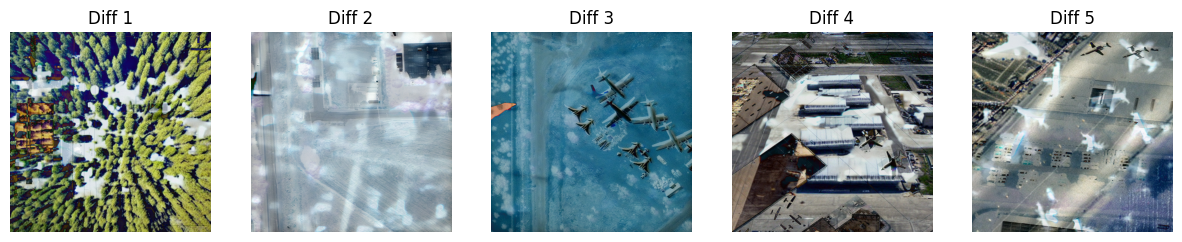

In [ ]:
# Display Compute Difference Images Function and Display the Differences

def compute_difference_images(original_images, generated_images):
    diff_images = []
    for orig, gen in zip(original_images, generated_images):
        orig_np = orig.permute(1, 2, 0).cpu().numpy()
        gen_np = gen.permute(1, 2, 0).cpu().numpy()
        diff_image = np.abs(orig_np - gen_np)
        diff_images.append(diff_image)
    return diff_images

def display_difference_images(original_images, generated_images, num_images=5):
    diff_images = compute_difference_images(original_images, generated_images)
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.title(f'Diff {i+1}')
        plt.imshow(diff_images[i])
        plt.axis('off')
    plt.show()

# Usage
display_difference_images(real_images, fake_images, num_images=5)

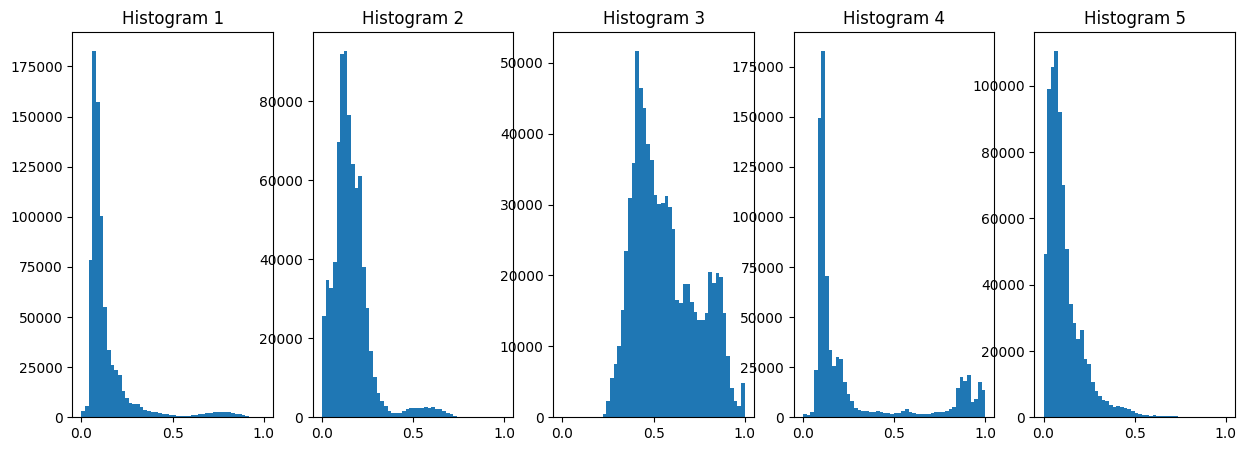

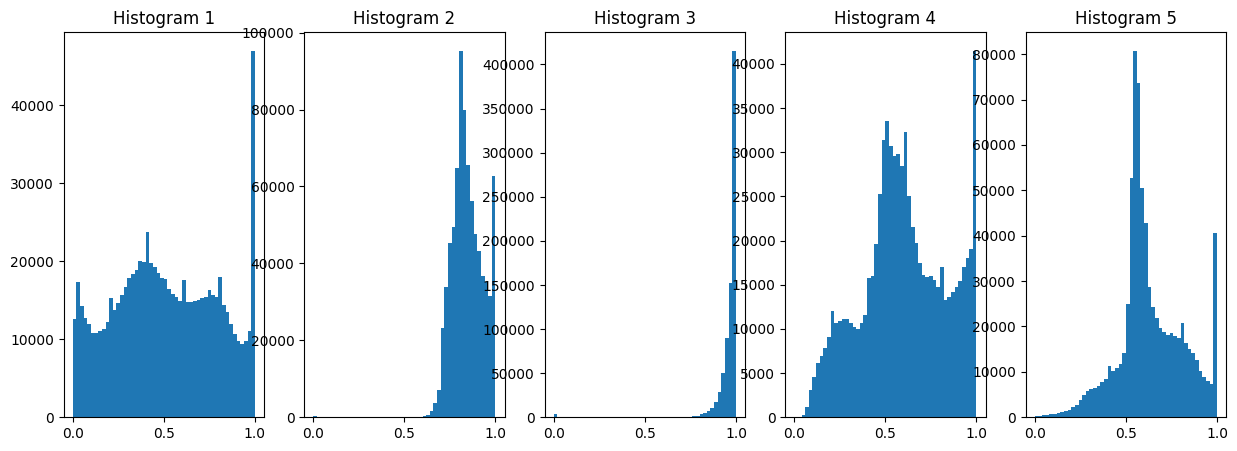

In [ ]:
# Plot the Histograms of Real vs Generated Images

def plot_histograms(images, num_images=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        img_np = images[i].permute(1, 2, 0).cpu().numpy().flatten()
        plt.subplot(1, num_images, i + 1)
        plt.hist(img_np, bins=50, range=(0, 1))
        plt.title(f'Histogram {i+1}')
    plt.show()

# Usage
plot_histograms(real_images, num_images=5)
plot_histograms(fake_images, num_images=5)

##Results

| Model Runs | Model Type | Model Parameter Changes | # of synthetic images generated | FID   | SSIM |
|------------|-------------|--------------------------|----------------------------------|-------|------|
| 0          | Manual      | N/A                      | 2000                             | 189.8 | 0.34 |
| 1          | Stable Diffusion - Inpainting not fine-tuned | None                      | 1000                             | 274.67 | 0.23 |
| 2          | Stable Diffusion - Inpainting fine-tuned    | Used 10 textual inversion images with hyperparameters | 1000 | 243.46 | 0.20 |
| 3          | Stable Diffusion - Inpainting fine-tuned    | Used 20 textual inversion images, added more prompt options | 1000 | 219.59 | 0.19 |
| 4          | Stable Diffusion - Inpainting fine-tuned    | Used 20 textual inversion images, added more prompt options, refined mask handling | 1000 | 221.41 | 0.19 |
